In [ ]:
### Dit is het BERT-model zoals het in de pipeline zit. Het bevat verschillende BERT-modellen en een analyse op 
### de resultaten van het trainen van het model. Vervolgens bevat het LIME en een sentiment analysis.
### This is the BERT-model as included in the pipeline. Here, various BERT-models can be trained and tested.
### This also includes an analysis of the results of training the models, as well as a LIME framework and some sentiment analysis.

In [2]:
# code aangepast van https://www.philschmid.de/bert-text-classification-in-a-different-language
# code edited from https://www.philschmid.de/bert-text-classification-in-a-different-language

# controleer dependencies en packages
# check dependencies

!ipython kernel install --user --name DataLabDisc
!which jupyter
!pip list

Installed kernelspec DataLabDisc in /data/milenadeswart/.local/share/jupyter/kernels/datalabdisc
/data/anaconda3/bin/jupyter
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Package                            Version
---------------------------------- -----------
absl-py                            2.1.0
accelerate                         0.20.1
aiohttp                            3.8.6
aiosignal                          1.3.1
alabaster                          0.7.12
alembic                            1.3.1
altair                             5.0.1
anaconda-client                    1.7.2
anaconda-navigator                 1.9.7
anaconda-project                   0.8.3
appdirs                            1.4.4
asn1crypto                         1.0.1
ast_decompiler                     0.7.0
astatine                           0.3.3
astor                   

tqdm                               4.66.2
traitlets                          5.9.0
transformers                       4.28.1
trl                                0.7.4
typed-ast                          1.4.3
typer                              0.4.2
typing_extensions                  4.7.1
typing-inspect                     0.9.0
tyro                               0.8.3
tzdata                             2024.1
tzlocal                            4.3.1
unicodecsv                         0.14.1
untokenize                         0.1.1
urllib3                            2.0.7
validators                         0.20.0
varint                             1.0.2
virtualenv                         20.16.2
wandb                              0.16.4
watchdog                           3.0.0
wcwidth                            0.1.7
webencodings                       0.5.1
websocket-client                   1.6.1
wemake-python-styleguide           0.16.1
Werkzeug                           2.2.3
wheel  

In [1]:
# importeer packages die nodig zijn
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics as metrics
from scipy.special import expit
import seaborn as sns
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import torch
import pyarrow
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import ClassificationArgs
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, accuracy_score
import lime
from lime.lime_text import LimeTextExplainer
import warnings
warnings.filterwarnings('ignore')

# zet seed voor consistentie
# set seed for consistency
seed = 9

ModuleNotFoundError: No module named 'datasets'

In [4]:
# check device waarop de code runt
# check the code device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [5]:
# gebruik pretrained model (cased!): https://huggingface.co/GroNLP/bert-base-dutch-cased
# using pretrained model
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
# inladen & mergen data
# load & merge data
def merge_annotated_data(naam_dataset, n_annotators, n_annotations = 3):
    """ functie die de gesplitste data gesplitst door split_annotated_data weer kan samenvoegen.
    De datasets met de naam naam_dataset_n_annotators.csv worden ingeladen. Vervolgens wordt de oorspronkelijke dataset gereconstrueerd
    uit de ingeladen data. De oorspronkelijke zinnen en het overzicht van de labels wordt gereturned.

    Input:
    naam_dataset: str, de naam van de documenen die de annotators hebben ingevuld
    n_annotators: int, het aantal annotators
    n_annotations: int, het aantal annotations per zin. default 3

    Output:
    merged_data: een DataFrame met daarin de oorspronkelijke data en de n_annotations labels die zijn toegekend.
    """

    """ function that can merge data split by split_annotated_data.
    The datasets with the name naam_dataset_n_annotators.csv are loaded. The original dataset then gets reconstructed
    from the loaded data. The original sentences and the overview of the original labels is returned.

    Input:
    name_dataset: str, the name of the documents that the annotators have filled in
    n_annotators: int, the number of annotators
    n_annotations: int, the number of annotations per sentence. Defaults to 3
    """
    
    # inladen path naar data en creëren lege frames
    # load data path and create empty frames
    dataset_path = "/data/rstudio/datasets/programma-discriminatie-en-racisme/Datasets_2/"
    merged_data = pd.DataFrame()

    for i in range(n_annotators):
        # inladen annotated documenten en samenvoegen
        # load and compile annotated documents
        annotated_doc = pd.read_excel(dataset_path + naam_dataset + "_" + str(i) + '.xlsx')
        annotated_doc = annotated_doc.dropna(subset=['Label', 'text', 'Column1'])
        # print(len(annotated_doc))
        columns = list(annotated_doc.columns)

        # document opstellen
        # set up dataframe
        if i == 0:
            merged_data = annotated_doc
        else:
            merged_data = pd.concat([merged_data, annotated_doc])
    
    # data toevoegen uit extra bronnen
    # add extra data
    extra_zoekwoorden = pd.read_excel(dataset_path + 'te_verwijderen.xlsx') # van tweede search / from second search
    merged_data = pd.concat([merged_data, extra_zoekwoorden])
    
    missende_zoekwoorden = pd.read_excel(dataset_path + 'missing_words.xlsx') # van derde search / from third search
    merged_data = pd.concat([merged_data, missende_zoekwoorden])
    
    extra_migratie = pd.read_excel(dataset_path + 'extra_migratie.xlsx') # extra data
    merged_data = pd.concat([merged_data, extra_migratie])
    
    herlabelled = pd.read_excel(dataset_path + 'herlabellen.xlsx') # hergelabelde data / re-annotated data
    merged_data = pd.concat([merged_data, herlabelled])
    
    #display(merged_data)
    
    # groepeer data
    # group data
    aggregated_data = merged_data.groupby(['Column1']).agg({'id': 'last', 'titel': 'last', 'text': 'last', 'zin': 'last', 'word': 'last', 'Label': 'last'})

    return pd.DataFrame(merged_data), pd.DataFrame(aggregated_data)

merged, aggregated = merge_annotated_data('te_labellen', n_annotators = 8, n_annotations = 3)

display(merged)

,Column1,id,pagina,zin,type_document,soort,document_nummer,titel,onderwerp,datum,...,word,categorie,doel,voorkeur,vermijden,toelichting,labeller_1,labeller_2,labeller_3,Column2
3,26136,9a3e78d8-05b3-4a31-b20e-a7a8ecf38006,18.0,51.0,Hoofddocument,Memorie van toelichting,2019D07551,Wijziging van de Wet langdurige zorg om toegan...,Memorie van toelichting,2019-02-20,...,stromen,migratie,context/vermijden,NaN,tsunami,NaN,1.0,2.0,3.0,NaN
5,18406,aa7d30cb-5023-4a90-bc82-8a4620a1f197,5.0,2.0,Hoofddocument,Nota n.a.v. het (nader/tweede nader/enz.) verslag,2014D12472,Voorstel van het lid Halsema tot wijziging van...,Nota naar aanleiding van het verslag,2007-01-25,...,macht,algemeen,context,NaN,NaN,NaN,1.0,2.0,3.0,NaN
6,9109,f0ab3dbd-32c1-41ab-ad8f-433c42ddaa2a,108.0,2.0,Hoofddocument,Memorie van toelichting,2009D43081,Vaststelling van de begrotingsstaten van het M...,Memorie van toelichting,2009-09-15,...,armoede,talen buiten nl,context,NaN,NaN,NaN,1.0,2.0,3.0,NaN
7,1887,fe98cf25-0b37-47d3-b866-0c1511139f66,41.0,13.0,Hoofddocument,Nota n.a.v. het (nader/tweede nader/enz.) verslag,2023D07671,Wijziging van het Wetboek van Strafrecht en an...,Nota naar aanleiding van het verslag,2023-03-09,...,seksueel,seksualiteit,context,NaN,NaN,NaN,1.0,2.0,3.0,NaN
9,139,4f54bb19-34ba-4db6-a301-017ba2bdbc42,45.0,12.0,Hoofddocument,Nota n.a.v. het (nader/tweede nader/enz.) verslag,2022D24395,Wijziging van het Wetboek van Burgerlijke Rech...,Nota naar aanleiding van het verslag,2022-06-20,...,stroom,migratie,context/vermijden,NaN,NaN,NaN,1.0,2.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,33861,fa1e13f1-67d0-4d3d-a2e9-decb637c5820,72,6,Hoofddocument,Rapport,2023D04549,Parlementaire enquête aardgaswinning Groningen,Deelrapport 2 - Feitenreconstructie 1959-2012,2023-02-24,...,kloof,gender,context,NaN,NaN,NaN,70.0,80.0,10.0,421.0
57,4478,d9bc4df6-5031-4ede-bdc6-22e827eb1de2,33,2,Hoofddocument,Nota n.a.v. het (nader/tweede nader/enz.) verslag,2016D45687,Wijziging van de Wet inburgering en enkele and...,Nota naar aanleiding van het verslag,2016-11-29,...,nieuwkomer,migratie,context,NaN,NaN,NaN,70.0,80.0,10.0,520.0
58,17405,497ce633-51c0-416d-a80d-8274f100d835,3,10,Hoofddocument,Memorie van toelichting (initiatiefvoorstel),2016D30337,Voorstel van wet van het lid Van Klaveren betr...,Memorie van toelichting,2016-07-18,...,minderheden,algemeen,context,NaN,NaN,"vermijd othering, rol slachtoffers",70.0,80.0,10.0,523.0
59,10024,0df009bc-3b60-4f2c-952c-49e27c7e4169,13,1,Hoofddocument,Memorie van toelichting,2015D32662,Vaststelling van de begrotingsstaten van het M...,Memorie van toelichting,2015-09-15,...,migranten,migratie,context,NaN,NaN,NaN,70.0,80.0,10.0,527.0


In [4]:
# bekijken dataset
# view dataset
print(merged.columns)

pos = len(aggregated[aggregated.Label == 1.0])
neg = len(aggregated[aggregated.Label==0.0])
unclear = len(aggregated[aggregated.Label==4.0])
useless = len(aggregated[aggregated.Label==7.0])

print(f"The dataset has {pos} biased and {neg} unbiased instances for a total of {pos+neg}. There are {unclear} unclear labels and {useless} useless instances.")

Index(['Column1', 'id', 'pagina', 'zin', 'type_document', 'soort',
       'document_nummer', 'titel', 'onderwerp', 'datum', 'vergaderjaar',
       'kamer', 'volgnummer', 'citeertitel', 'alias', 'datum_registratie',
       'datum_ontvangst', 'aanhangselnummer', 'kenmerk_afzender',
       'organisatie', 'content_type', 'content_length', 'gewijzigd_op',
       'api_gewijzigd_op', 'verwijderd', 'url_document', 'id_hoofddocument',
       'text', 'Label', 'word', 'categorie', 'doel', 'voorkeur', 'vermijden',
       'toelichting', 'labeller_1', 'labeller_2', 'labeller_3', 'Column2'],
      dtype='object')
The dataset has 894 biased and 2738 unbiased instances for a total of 3632. There are 32 unclear labels and 1010 useless instances.


In [5]:
# vinden zoekwoorden die wel en niet aanwezig zijn in de dataset
# view search words present and absent in the dataset
zoekwoorden_set = set(merged['word'])

print(len(zoekwoorden_set))

zoekwoorden = ['meerbloed', 'hij of zij', 'rolstoelgebonden', 'Andere achtergrond', 'westers', 'mbo-leerling', 'slaven', 'berber', 'joods', 'zwarte school', 'grensoverschrijdend gedrag', 'halfbloed', 'gekleurd', 'hij/zij', 'ontwikkelingslanden', 'plusklassen', 'doventolk', 'probleembuurt', 'zittenblijven', 'zwart', 'lager opgeleid', 'minderheden', 'handicap', 'blank', 'kaukasisch', 'juf ', 'begeleider', 'mohammedaan', 'gebarentolk', 'etnisch', 'bruin', 'thuiszitter', 'stroom', 'derde wereld', 'privilege', 'islam ', 'fobie', 'dubbelbloed', 'stromen', 'non-binair', 'inheems', 'ras', 'excellente school', 'speciaal onderwijs', 'gouden eeuw', 'transseksueel', 'man', 'page', 'rolstoeler', 'ontdekken', 'anderstalig', 'opstromen', 'caribisch gebied', 'gehandicapt', 'rolstoelrijder', 'slavernijverleden', 'hoogopgeleid', 'travestiet', 'tussenpositie', 'witte school', 'slaaf', 'mavo', 'racisme', 'hoofddoek', 'jongen', 'achterstandsscore', 'turk', 'ontdekking', 'medicijnman', 'bediende', 'zigeuner', 'nieuwkomer', 'afstromen', 'arabisch', 'macht', 'exotisch', 'islamiet', 'eskimo', 'oostblok', 'laag opgeleid', 'transgender', 'geslacht', 'armoede', 'lagelonenlanden', 'bi-cultureel', 'verliefd', 'probleemkinderen', 'mbo-cursist', 'ouders', 'hermafrodiet', 'probleemwijk', 'achterstandsschool', 'primitief', 'praktisch geschoold', 'christen', 'mbo-deelnemer', 'dames en heren', 'kloof', 'vluchtelingencrisis', 'achterstandsleerling', 'nieuwe nederlander', 'indiaan', 'queer', 'autochtoon', 'theoretisch geschoold', 'donker', 'meisje', 'allochtoon', 'bicultureel', 'hetero', 'west', 'homo', 'laagopgeleid', 'vrouw', 'seksueel', 'traditie', 'passend onderwijs', 'migranten', 'dwerg', 'achterstandsscholen']
zoekwoorden = set(zoekwoorden)

afwezig = zoekwoorden - zoekwoorden_set
print(len(afwezig))

print(afwezig)

53
71
{'kaukasisch', 'zwarte school', 'hij/zij', 'bediende', 'dubbelbloed', 'dames en heren', 'speciaal onderwijs', 'meerbloed', 'laag opgeleid', 'doventolk', 'passend onderwijs', 'lager opgeleid', 'halfbloed', 'probleembuurt', 'rolstoelrijder', 'ontdekking', 'travestiet', 'probleemkinderen', 'bi-cultureel', 'bicultureel', 'mohammedaan', 'theoretisch geschoold', 'Andere achtergrond', 'juf ', 'excellente school', 'nieuwe nederlander', 'handicap', 'zwart', 'page', 'dwerg', 'berber', 'autochtoon', 'mbo-leerling', 'transseksueel', 'lagelonenlanden', 'gekleurd', 'zigeuner', 'derde wereld', 'caribisch gebied', 'witte school', 'ontdekken', 'indiaan', 'rolstoeler', 'eskimo', 'exotisch', 'mbo-cursist', 'bruin', 'donker', 'allochtoon', 'turk', 'achterstandsschool', 'grensoverschrijdend gedrag', 'rolstoelgebonden', 'medicijnman', 'non-binair', 'mavo', 'islamiet', 'westers', 'achterstandsscore', 'plusklassen', 'primitief', 'praktisch geschoold', 'mbo-deelnemer', 'queer', 'islam ', 'gouden eeuw', '

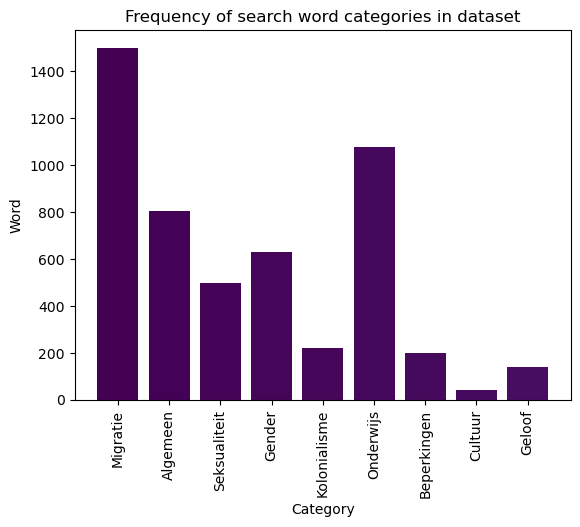

{'Migratie': 1501, 'Algemeen': 803, 'Seksualiteit': 499, 'Gender': 630, 'Kolonialisme': 220, 'Onderwijs': 1078, 'Beperkingen': 200, 'Cultuur': 43, 'Geloof': 140}


In [6]:
# overzicht van de zoekwoorden en de categorieën aanwezig in de dataset
# give overview of search words & their categories in the dataset
dataset_path = "/data/rstudio/datasets/programma-discriminatie-en-racisme/" 

zoekwoorden = pd.read_excel(dataset_path + "Zoekwoorden15.03.24.xlsx", names = ['Categorie', 'Zoekwoord', 'Doel', 'Voorkeur', 'Vermijden', 'Toelichting'])

search_dict = dict(zip(zoekwoorden['Zoekwoord'], zoekwoorden['Categorie']))
#print(search_dict)

# leuk grafiekje van hoe vaak woorden voorkomen
# little graph of how often words occur
word_freq = {}
i = 0

for woord in merged['word']:
    category = search_dict[woord]
    
    if category in word_freq:
        word_freq[category] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[category] = 1
        
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Word')
plt.title('Frequency of search word categories in dataset')
plt.show()

print(word_freq)

In [7]:
print(len(aggregated))

# prepareer dataset voor inladen in model
# prep dataset for loading into model
model_data = aggregated[aggregated.Label < 2.0] # dit zijn de labels 0 en 1 / these are the labels 0 and 1

model_data = model_data.drop(columns = ['id', 'titel', 'zin'])
model_data = model_data.rename(columns={"Label": "label", 'text': 'text'}) # totaalscore/label = doel, text = ingelezen tekst

display(model_data)

4679


,text,word,label
Column1,,,
38,door tegelijkertijd voor werkgevers de verschi...,stromen,0.0
50,de regering is zich zeer bewust van de nederla...,traditie,0.0
53,dienovereenkomstig streeft elke partij ernaar ...,stromen,0.0
110,tweede kamer der staten-generaal 2 vergaderjaa...,hetero,0.0
112,b in de beweegreden wordt «hetero- of homoseks...,hetero,0.0
...,...,...,...
9870,ten aanzien van studenten die tijdelijk een an...,stromen,0.0
9874,een functiestoornis is een langdurige of blijv...,fobie,1.0
9910,een prejudiciële procedure is daarmee niet all...,macht,0.0


In [8]:
# hoe vaak komt elk woord voor in de zoekwoordenlijst?
# find frequency of search words 
word_freq_dict = {}

for woord in model_data['word']:
    if woord in word_freq_dict:
        word_freq_dict[woord] += 1
    else:
        word_freq_dict[woord] = 1
        
print(word_freq_dict)

# vinden woorden die < 10 keer voorkomen
# find words that appear < 10 times
new_words_list = []

for key in word_freq_dict:
    value = word_freq_dict[key]
    if value < 10:
        new_words_list.append(key)
        
print(new_words_list)

# verwijderen woorden die weinig voorkomen voor aparte test set
# then, remove instances with key words from this unseen words list for a separate test set
new_words_data = pd.DataFrame()

for new_word in new_words_list:
    new_word_data = model_data[model_data['word'] == new_word]
    new_words_data = pd.concat([new_words_data, new_word_data])

display(new_words_data)

model_data = model_data[~model_data['word'].isin(new_words_data['word'])]
display(model_data)

{'stromen': 521, 'traditie': 38, 'hetero': 53, 'stroom': 473, 'macht': 365, 'geslacht': 255, 'armoede': 214, 'seksueel': 376, 'migranten': 161, 'ouders': 205, 'christen': 38, 'gehandicapt': 146, 'racisme': 31, 'minderheden': 63, 'mankracht': 90, 'meisje': 77, 'afstromen': 19, 'islam': 48, 'zittenblijven': 20, 'homo': 15, 'joods': 16, 'privilege': 20, 'blank': 9, 'hoogopgeleid': 40, 'nieuwkomer': 13, 'opstromen': 9, 'anderstalig': 51, 'slaaf': 12, 'slavernijverleden': 26, 'laagopgeleid': 26, 'kloof': 23, 'slaven': 9, 'transgender': 65, 'jongen': 15, 'arabisch': 31, 'vluchtelingencrisis': 8, 'fobie': 5, 'hoofddoek': 17, 'thuiszitter': 4, 'achterstandsleerling': 2, 'juf': 9, 'verliefd': 4, 'inheems': 6, 'tussenpositie': 3, 'oostblok': 1}
['blank', 'opstromen', 'slaven', 'vluchtelingencrisis', 'fobie', 'thuiszitter', 'achterstandsleerling', 'juf', 'verliefd', 'inheems', 'tussenpositie', 'oostblok']


,text,word,label
Column1,,,
3678,"blank en haelermans, die in het antwoord op vr...",blank,0.0
36171,met recht kunnen we spreken over illusies van ...,blank,0.0
36171,met recht kunnen we spreken over illusies van ...,blank,0.0
3677,niet-dossierstuk over de afgelopen twintig jaa...,blank,0.0
3678,"blank en haelermans, die in het antwoord op vr...",blank,0.0
...,...,...,...
25098,"de wet verbiedt het doden, het vangen en het v...",inheems,0.0
15972,in de structuur van het huidige en het nieuwe ...,tussenpositie,0.0
5006,de nla verzoekt te bezien of het mogelijk is o...,tussenpositie,0.0


,text,word,label
Column1,,,
38,door tegelijkertijd voor werkgevers de verschi...,stromen,0.0
50,de regering is zich zeer bewust van de nederla...,traditie,0.0
53,dienovereenkomstig streeft elke partij ernaar ...,stromen,0.0
110,tweede kamer der staten-generaal 2 vergaderjaa...,hetero,0.0
112,b in de beweegreden wordt «hetero- of homoseks...,hetero,0.0
...,...,...,...
9869,ten aanzien van studenten die tijdelijk een an...,stromen,0.0
9870,ten aanzien van studenten die tijdelijk een an...,stromen,0.0
9910,een prejudiciële procedure is daarmee niet all...,macht,0.0


In [9]:
# implementeer undersampling, oversampling, normaal sampling
# implementing different sampling strategy
def sampling_strategy(input_frame, strategy = 'normal', max = 0.7, balance = 0.5):
    if strategy == 'oversampling': # F1 = 0.78
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        output_frame = pd.concat([pos, pos, neg]) # double the sample of positive instances
        
    elif strategy == 'undersampling': # F1 = 0.80
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        max_len = int(max*len(neg))
        output_frame = pd.concat([pos, neg[0:max_len]])
        
    elif strategy == 'balanced': # F1 = 0.78
        # len(input_frame) = len(output_frame)
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        neg_len = int(len(input_frame) * balance)
        pos_extra_len = len(input_frame) - neg_len - len(pos)
        output_frame = pd.concat([pos, neg[0:neg_len]])
        
        while pos_extra_len/len(pos) > 1:
            output_frame = pd.concat([output_frame, pos]) # heel extra frame toevoegen / add an entirely new frame
            pos_extra_len -= len(pos)
            
        # anders: overig toevoegen
        # else: add however much is remainng
        output_frame = pd.concat([output_frame, pos[0:pos_extra_len]])
    
    else: #strategy = 'normal' # F1 = 0.78
        output_frame = input_frame[input_frame.label < 2.0] # behoudt alleen labels 0 en 1
    return output_frame

In [13]:
# split dataset: 60% train, 20% val, 20% test
train_val_df, test_df_words = train_test_split(model_data, test_size=0.20, stratify = model_data['label'], random_state=seed)
train_df_words, val_df_words = train_test_split(train_val_df, test_size=0.25, stratify = train_val_df['label'], random_state=seed)

train_df_words = sampling_strategy(train_df_words, strategy = 'undersampling', max = 0.8)

train_df = train_df_words.drop(columns = ['word'])
val_df = val_df_words.drop(columns = ['word'])
test_df = test_df_words.drop(columns = ['word'])
new_test_df = new_words_data.drop(columns = ['word'])

print(len(train_df), len(val_df), len(test_df))
print(len(train_df[train_df['label']==1.0]))

output_path = '/data/rstudio/datasets/programma-discriminatie-en-racisme/'

test_df.to_csv(output_path + 'test_df.csv')
new_test_df.to_csv(output_path + 'new_test_df.csv')

1811 713 713
511


In [14]:
# vind de zoekwoorden die niet in de dataset zitten
# find the search words missing from the dataset
zoekwoorden_set = set(test_df_words['word'])

print(len(zoekwoorden_set))

zoekwoorden = set(merged['word'])

afwezig = zoekwoorden - zoekwoorden_set
print(len(afwezig))
print(afwezig)

33
20
{nan, 'blank', 'fobie', 'juf', 'oostblok', 'vrouw', 'achterstandsleerling', 'vluchtelingencrisis', 'opstromen', 'ras', 'verliefd', 'inheems', 'etnisch', 'thuiszitter', 'west', 'ontwikkelingslanden', 'tussenpositie', 'man', 'begeleider', 'slaven'}


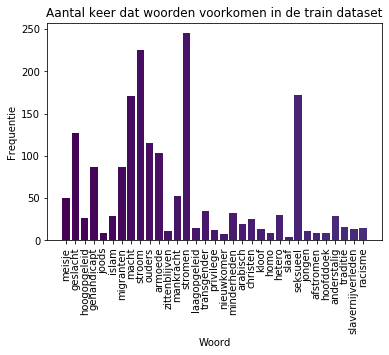

{'meisje': 50, 'geslacht': 127, 'hoogopgeleid': 26, 'gehandicapt': 87, 'joods': 9, 'islam': 29, 'migranten': 87, 'macht': 171, 'stroom': 225, 'ouders': 115, 'armoede': 103, 'zittenblijven': 11, 'mankracht': 52, 'stromen': 245, 'laagopgeleid': 14, 'transgender': 35, 'privilege': 12, 'nieuwkomer': 8, 'minderheden': 32, 'arabisch': 19, 'christen': 25, 'kloof': 13, 'homo': 9, 'hetero': 30, 'slaaf': 4, 'seksueel': 172, 'jongen': 11, 'afstromen': 9, 'hoofddoek': 9, 'anderstalig': 29, 'traditie': 16, 'slavernijverleden': 13, 'racisme': 14}


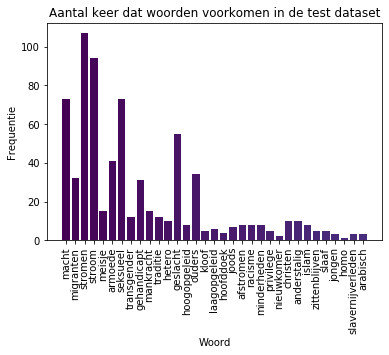

{'macht': 73, 'migranten': 32, 'stromen': 107, 'stroom': 94, 'meisje': 15, 'armoede': 41, 'seksueel': 73, 'transgender': 12, 'gehandicapt': 31, 'mankracht': 15, 'traditie': 12, 'hetero': 10, 'geslacht': 55, 'hoogopgeleid': 8, 'ouders': 34, 'kloof': 5, 'laagopgeleid': 6, 'hoofddoek': 4, 'joods': 7, 'afstromen': 8, 'racisme': 8, 'minderheden': 8, 'privilege': 5, 'nieuwkomer': 2, 'christen': 10, 'anderstalig': 10, 'islam': 8, 'zittenblijven': 5, 'slaaf': 5, 'jongen': 3, 'homo': 1, 'slavernijverleden': 3, 'arabisch': 3}


In [15]:
# hoe vaak zitten woorden in de train set?
# how often are words present in the training set?
word_freq = {}

for woord in train_df_words['word']:
    if woord in word_freq:
        word_freq[woord] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[woord] = 1

# plot
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de train dataset')
plt.show()

print(word_freq)

# en in de test set?
# and the test set?
word_freq = {}

for woord in test_df_words['word']:
    if woord in word_freq:
        word_freq[woord] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[woord] = 1

# plot
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de test dataset')
plt.show()

print(word_freq)

In [24]:
# hyperparameters zetten
# define hyperparameters
# to change parameters: zie https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
train_args ={"reprocess_input_data": True, # tokenization gebeurt binnen model
             "fp16":False, # vorm van de input van de data
             "silent": False, # zeker weten dat progress bars worden geprint
             "use_multiprocessing": False, # versnelt training
             "use_multiprocessing_for_evaluation": False, # versnelt training
             "overwrite_output_dir": True, # niet ieder model opslaan
             "save_total_limit": 2, # slaat meest recente en beste epoch op
             "save_strategy": 'no', # niet tussentijds opslaan
             "load_best_model_at_end": True, # het beste model inladen
             "num_train_epochs": 4, # hoeveel epochs
             "learning_rate": 0.00002, # learning rate
             "weight_decay": 0.1,
             "optimizer": 'AdamW',
             #"loss_type": "custom",
             #"hidden_dropout_prob": 0.5,
             "evaluate_during_training": True, # om validation data in te laten
            "evaluation_strategy":"epoch", # slaat een tussentijds model op om te evalueren
            #"eval_steps": 2000, # hoe vaak het model wordt opgeslagen
            "train_batch_size": 8, # batch size trainingsdata
            "eval_batch_size": 8} # batch size validation data

model_args = ClassificationArgs()
model_args.reprocess_input_data = True
model_args.fp16 = False
model_args.silent = False
model_args.use_multiprocessing = False
model_args.use_multiprocessing_for_evaluation = False
model_args.overwrite_output_dir = True
model_args.save_total_limit = 2
model_args.save_strategy = "no"
model_args.load_best_model_at_end = True
model_args.num_train_epochs = 4
model_args.learning_rate = 0.00002
model_args.optimizer = "AdamW"
model_args.relative_step = True
model_args.warmup_init = True
model_args.evaluation_during_training = True
model_args.evaluation_strategy = "epoch"
model_args.hidden_dropout_prob = 0.3
model_args.train_batch_size = 8
model_args.eval_batch_size = 8
model_args.no_cache = False

model_args.loss_type = 'focal' # 'focal' or 'dice' or 'tversky' # bron: https://github.com/amaiya/ktrain/issues/228
model_args.loss_args = {
            'alpha': None,
            'gamma': 2,
            'reduction': 'mean',
            'ignore_index': -100,
        }

# selecteer het gewenste model
# Create a ClassificationModel (code uit bron; zie bovenaan notebook)
model = ClassificationModel(
    "bert", "GroNLP/bert-base-dutch-cased", # Nederlands!!
    #"bert", "bert-base-uncased", # English!!
    #"roberta", "pdelobelle/robbert-v2-dutch-base", # RobBERT
    # "bert", "GroNLP/bert_dutch_base_offensive_language", # hateBERT
    #"bert", "DeepPavlov/bert-base-multilingual-cased-sentence", # multi-lingual sentenceBERT (https://huggingface.co/DeepPavlov/bert-base-multilingual-cased-sentence)
    num_labels=2, # hoeveel mogelijke targets er zijn
    args=train_args,
    #weight = [1, 3],
    use_cuda=False # omdat dit op de cpu draait
)

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', '

In [19]:
# om f1 te kunnen genereren
# to generate f1-score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

Running Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]

In [25]:
# testen voor trainen
# zero-shot testing
result_zero, model_outputs_zero, wrong_predictions_zero = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)
print(result_zero)

result_zero_new, model_outputs_zero_new, wrong_predictions_zero_new = model.eval_model(new_test_df, f1=f1_multiclass, acc=accuracy_score)
print(result_zero_new)

Running Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]

{'mcc': -0.03755754302865606, 'tp': 11, 'tn': 494, 'fp': 48, 'fn': 160, 'auroc': 0.46798191666127187, 'auprc': 0.22351145922038324, 'f1': 0.4608695652173913, 'acc': 0.7082748948106592, 'eval_loss': 0.6592687057124244}


Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

{'mcc': -0.2090694174717135, 'tp': 0, 'tn': 26, 'fp': 2, 'fn': 41, 'auroc': 0.29660278745644597, 'auprc': 0.472520361594314, 'f1': 0.2736842105263158, 'acc': 0.37681159420289856, 'eval_loss': 0.7290976511107551}


In [73]:
# trainen!
train_results = model.train_model(train_df = train_df, eval_df = val_df)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/227 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/227 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/227 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/227 [00:00<?, ?it/s]

In [ ]:
# testen na trainen
# testing after training
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)

In [75]:
# resultaten: mcc = , tp = true positives, tn = true negatives, fp = false negatives, fn = false negatives
print(result)

# 0.7806059741456883, lr = 0.00002, batch = 8, oversampling
# 0.7618282264590501, lr = 0.002, batch = 8, oversampling
# 0.80, lr = default, batch = 8, undersampling
# 0.7892210553443721, lr = 0.00002, batch = 24, oversampling
# 0.7727849196570864, lr = 0.00002, batch = 24, balanced sampling
# 0.7643486483807626, lr = 0.00002, batch = 24, undersampling
# 0.7721387757070184, lr = 0.0002, batch = 24, undersampling
# 0.7656888451873702, lr = default, batch = 8, undersampling
# 0.7819736575481258, batch = 24, epochs = 8, oversampling (doubled)
# 0.7618978588149389, hidden dropout of 0.5, balanced sampling
# 0.7750330201139665, dropout 0.8, balanced sampling
# 0.7470579808026853, category = oversampling
# 0.7551529031388926, dropout 0.5, batch size = 4
# 0.7599348682562457, weight decay = 0.01
# 0.68260712156061, lr = 0.000002, weight decay = 0.1, batch = 8
# 0.6687961596234598, lr = 0.000002, weight decay = 0
# 0.7672738336177362, lr = 0.00002, weight decay = 0.1, batch = 24
# 0.7565585210545067, epochs = 8, weight decay = 0.2
# 0.7620034919249236, epochs = 8, batch = 8, weight decay = 0.2
# 0.758152920054916, epochs = 16
# 0.7524879530693485, epochs = 7, weight decay = 0.15
# 0.7834716024780142, batch size = 4. weight decay = 0.1
# 0.7808517733050566, weight decay = 0.15
# 0.7731042768563656, weight decay = 0.0, lr = 0.00005
# 0.7701744552093489, lr = 0.00002
# 0.7785754688247835, weight decay = 0.1, lr = 0.00005
# 0.7741168524147247, lr = 0.00001
# 0.7760263421941465, lr = 0.00004, batch = 8
# 0.7696694476713486, dropout = 0.3

# REMOVAL OF UNSEEN WORDS
# 0.7804854943753701

# 50% undersampling: 0.8023298390977758
# 30% undersampling: 0.7575958508245064
# 90% undersampling: 0.8090384967790136
# 80% undersampling: 0.8069071847055194

# SentenceBERT
# 0.7851469867647713, 0.39015151515151514

# focal loss
# 0.7947628030461819, 0.5241379310344827

# dice loss 
# 0.8006020925182602, 0.5739833936555248

{'mcc': 0.6250343216674076, 'tp': 119, 'tn': 498, 'fp': 44, 'fn': 52, 'auroc': 0.8879340109190564, 'auprc': 0.7784109885536891, 'f1': 0.8123313811936566, 'acc': 0.8653576437587658, 'eval_loss': 0.6586236819883602}


In [19]:
# hertesten op ongeziene woorden
# test on unseen words
new_test_df = new_words_data.drop(columns = ['word'])

new_result, new_model_outputs, new_wrong_predictions = model.eval_model(new_test_df, f1=f1_multiclass, acc=accuracy_score)

print(new_result)

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

{'mcc': 0.31419033670894986, 'tp': 14, 'tn': 26, 'fp': 2, 'fn': 27, 'auroc': 0.6054006968641115, 'auprc': 0.731919868063147, 'f1': 0.5666016894087069, 'acc': 0.5797101449275363, 'eval_loss': 2.022696591085858}


(908, defaultdict(<class 'list'>, {'global_step': [227, 454, 681, 908], 'train_loss': [1.4636650085449219, 0.04790273681282997, 0.004960660357028246, 0.001977277221158147], 'mcc': [0.5159964098340479, 0.5847136130789417, 0.5744061835662498, 0.566286764663319], 'tp': [58, 106, 106, 105], 'tn': [540, 504, 501, 500], 'fp': [2, 38, 41, 42], 'fn': [113, 65, 65, 66], 'auroc': [0.8570542284370213, 0.8654485229062817, 0.8495446796573227, 0.8472357091991972], 'auprc': [0.7416607363254223, 0.746661026720385, 0.7422759235297361, 0.7384167324238798], 'eval_loss': [0.4437642109269897, 0.4284555573740767, 0.6283418796995345, 0.7288134648270594]}))


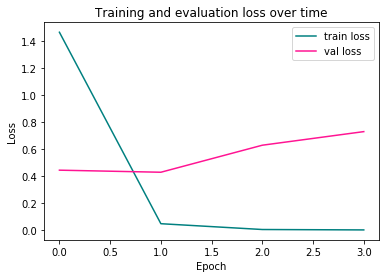

In [55]:
# maak een plotje van de loss
# plot the loss
print(train_results)

train_losses = train_results[1]['train_loss']
eval_losses = train_results[1]['eval_loss']

plt.plot(train_losses, c = 'teal', label = 'train loss')
plt.plot(eval_losses, c = 'deeppink', label = 'val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and evaluation loss over time')
plt.show()

In [57]:
# vind F1-score over iedere epoch
# find F1-score  over epochs
tp = train_results[1]['tp']
fp = train_results[1]['fp']
tn = train_results[1]['tn']
fn = train_results[1]['fn']

f1s = []

for i in range(len(tp)):
    precision = tp[i]/(tp[i]+fp[i])
    recall = tp[i]/(tp[i]+fn[i])
    f1 = 2*((precision * recall)/(precision + recall))
    f1s.append(f1)
    
print(f1s)

[0.5021645021645021, 0.6730158730158731, 0.6666666666666667, 0.6603773584905661]


In [21]:
# van de outputs naar het model naar de voorspellingen voor elke categorie
# transform outputs to predicted probabilities
print(model_outputs)

probabilities = expit(model_outputs) # dit is de sigmoid van de voorspelling
print(probabilities)

[[ 3.84118128 -3.8337388 ]
 [-0.55939764  1.02337193]
 [ 4.08759356 -3.95778251]
 ...
 [ 1.56246972 -1.33446503]
 [ 3.30820465 -3.2237165 ]
 [ 3.48846984 -3.46712995]]
[[0.97898297 0.02117071]
 [0.36368685 0.73562889]
 [0.98349734 0.01874726]
 ...
 [0.82670746 0.20842176]
 [0.96470921 0.03828292]
 [0.97035791 0.03026209]]


In [46]:
# vind voorspellingen voor de outputs
# predictions of model outputs
predictions, raw_outputs = model.predict(list(test_df['text']))

new_predictions, new_raw_outputs = model.predict(list(new_test_df['text']))

  0%|          | 0/90 [00:00<?, ?it/s]

[0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 

  0%|          | 0/9 [00:00<?, ?it/s]

In [23]:
# hier kun je zinnen testen en zien wat het model voorspelt
# test any sentence you like on the model
text = ['het zijn ook altijd de mannen die hun zaken niet op orde hebben']

print(str(model.predict(text)[0]))

  0%|          | 0/1 [00:00<?, ?it/s]

[[ 1.01428187 -0.94758391]]


In [47]:
print(predictions)
print(list(test_df['label']))

# lees uit of de voorspellingen correct zijn
# get correctness of predictions
correct = []

for i in range(len(predictions)):
    if predictions[i] == list(test_df['label'])[i]:
        correct.append(1)
    else:
        correct.append(0)

print(new_predictions)
print(list(new_test_df['label']))

713
[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

0.672514619883041 0.9261992619926199 0.07380073800738007 0.32748538011695905
115 502 40 56


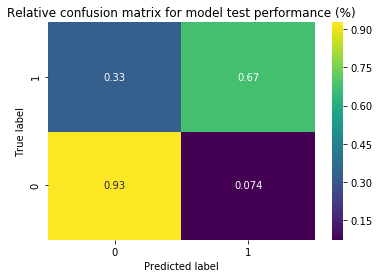

In [25]:
# confusion matrix
tp = result['tp']
tn = result['tn']
fp = result['fp']
fn = result['fn']
total = tp+tn+fp+fn

tp_rel = tp/(tp+fn)
tn_rel = tn/(tn+fp)
fp_rel = fp/(tn+fp)
fn_rel = fn/(tp+fn)

print(tp_rel, tn_rel, fp_rel, fn_rel)
print(tp, tn, fp, fn)

cm = np.array([[tn_rel, fp_rel], [fn_rel, tp_rel]])
ax = sns.heatmap(cm, annot = True, cmap = "viridis")
ax.set_ylim([0,2])
plt.title("Relative confusion matrix for model test performance (%)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

          guess 0     guess 1  correct
count  617.000000  617.000000    617.0
mean     0.793357    0.209898      1.0
std      0.340127    0.342173      0.0
min      0.019753    0.013192      1.0
25%      0.850963    0.020778      1.0
50%      0.972846    0.028140      1.0
75%      0.981080    0.152383      1.0
max      0.986748    0.984417      1.0
         guess 0    guess 1  correct
count  96.000000  96.000000     96.0
mean    0.593420   0.411393      0.0
std     0.384829   0.385502      0.0
min     0.024136   0.017419      0.0
25%     0.147070   0.043039      0.0
50%     0.761947   0.258652      0.0
75%     0.957080   0.877990      0.0
max     0.982244   0.981578      0.0


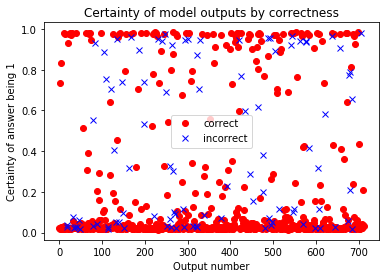

In [67]:
# onzekerheid van model
# uncertainty of model
prob_df = pd.DataFrame(probabilities, columns = ['guess 0', 'guess 1'])
prob_df['correct'] = correct

print(prob_df[prob_df['correct'] == 1].describe())
print(prob_df[prob_df['correct'] == 0].describe())

plt.plot(prob_df['guess 1'][prob_df['correct'] == 1], 'ro', label = 'correct')
plt.plot(prob_df['guess 1'][prob_df['correct'] == 0], 'bx', label = 'incorrect')
plt.ylabel("Certainty of answer being 1")
plt.xlabel("Output number")
plt.title("Certainty of model outputs by correctness")
plt.legend()
plt.show()

{'macht': 0.958904109589041, 'migranten': 0.75, 'stromen': 0.8878504672897196, 'stroom': 0.9893617021276596, 'meisje': 0.7333333333333333, 'armoede': 0.9024390243902439, 'seksueel': 0.8904109589041096, 'transgender': 0.5833333333333334, 'gehandicapt': 0.9032258064516129, 'mankracht': 0.9333333333333333, 'traditie': 0.8333333333333334, 'hetero': 1.0, 'geslacht': 0.6545454545454545, 'hoogopgeleid': 1.0, 'ouders': 0.7941176470588235, 'kloof': 0.6, 'laagopgeleid': 1.0, 'hoofddoek': 0.5, 'joods': 0.7142857142857143, 'afstromen': 0.875, 'racisme': 1.0, 'minderheden': 0.5, 'privilege': 1.0, 'nieuwkomer': 0.0, 'christen': 1.0, 'anderstalig': 0.9, 'islam': 0.75, 'zittenblijven': 1.0, 'slaaf': 0.6, 'jongen': 0.6666666666666666, 'homo': 1.0, 'slavernijverleden': 1.0, 'arabisch': 1.0}


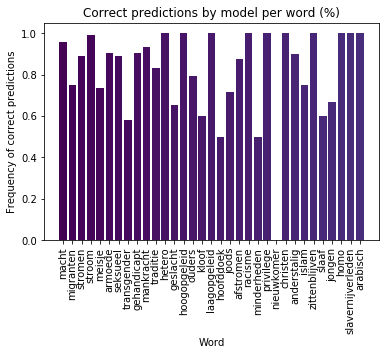

In [27]:
# kijken naar betrouwbaarheid per zoekwoord
# look at the correct predictions for each search word
test_df_words['predicted'] = predictions

dict_word_totals = {}
dict_word_correct = {}
dict_word_relative = {}

dict_label_totals = {}
dict_label_pos = {}
dict_label_relative = {}

for i in range(len(test_df_words)):
    woord = test_df_words['word'].iloc[i]
    label = test_df_words['label'].iloc[i]
    if woord not in dict_word_totals:
        dict_word_totals[woord] = 1
        dict_word_relative[woord] = 0
        dict_label_totals[woord] = 1
        dict_label_relative[woord] = 0
        
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] = 1
        else:
            dict_word_correct[woord] = 0
        
        if label == 1:
            dict_label_pos[woord] = 1
        else:
            dict_label_pos[woord] = 0
            
    else:
        dict_word_totals[woord] += 1
        dict_label_totals[woord] +=1
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] += 1
        if label == 1:
            dict_label_pos[woord] += 1
        
    dict_word_relative[woord] = dict_word_correct[woord]/dict_word_totals[woord]
    dict_label_relative[woord] = dict_label_pos[woord]/dict_label_totals[woord]
            
print(dict_word_relative)

n=len(dict_word_relative)
r = np.arange(n) 
width = 0.25

plt.bar(dict_word_relative.keys(), dict_word_relative.values(), color = mycmap)
#plt.bar(dict_label_relative.keys(), dict_label_relative.values(), color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency of correct predictions')
plt.title('Correct predictions by model per word (%)')
plt.show()

# TODO: TOEVOEGEN HOE VEEL VAN DE WOORDEN EEN 1 ZIJN

{'blank': 1.0, 'opstromen': 0.6666666666666666, 'slaven': 0.3333333333333333, 'vluchtelingencrisis': 0.125, 'fobie': 0.8, 'thuiszitter': 0.5, 'achterstandsleerling': 1.0, 'juf': 0.3333333333333333, 'verliefd': 0.25, 'inheems': 1.0, 'tussenpositie': 1.0, 'oostblok': 0.0}
{'blank': 0.0, 'opstromen': 0.8888888888888888, 'slaven': 1.0, 'vluchtelingencrisis': 0.875, 'fobie': 0.2, 'thuiszitter': 1.0, 'achterstandsleerling': 1.0, 'juf': 0.6666666666666666, 'verliefd': 0.75, 'inheems': 0.0, 'tussenpositie': 0.0, 'oostblok': 1.0}


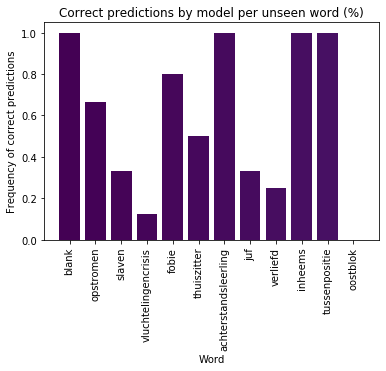

In [28]:
# herhaal voor ongeziene woorden
# repeat for the unseen words
new_test_df['predicted'] = new_predictions

dict_word_totals = {}
dict_word_correct = {}
dict_word_relative = {}

dict_label_totals = {}
dict_label_pos = {}
dict_label_relative = {}

for i in range(len(new_words_data)):
    woord = new_words_data['word'].iloc[i]
    label = new_words_data['label'].iloc[i]
    if woord not in dict_word_totals:
        dict_word_totals[woord] = 1
        dict_word_relative[woord] = 0
        dict_label_totals[woord] = 1
        dict_label_relative[woord] = 0
        
        if new_test_df['predicted'].iloc[i] == new_test_df['label'].iloc[i]:
            dict_word_correct[woord] = 1
        else:
            dict_word_correct[woord] = 0
        
        if label == 1:
            dict_label_pos[woord] = 1
        else:
            dict_label_pos[woord] = 0
            
    else:
        dict_word_totals[woord] += 1
        dict_label_totals[woord] +=1
        if new_test_df['predicted'].iloc[i] == new_test_df['label'].iloc[i]:
            dict_word_correct[woord] += 1
        if label == 1:
            dict_label_pos[woord] += 1
        
    dict_word_relative[woord] = dict_word_correct[woord]/dict_word_totals[woord]
    dict_label_relative[woord] = dict_label_pos[woord]/dict_label_totals[woord]
            
print(dict_word_relative)
print(dict_label_relative)

n=len(dict_word_relative)
r = np.arange(n) 
width = 0.25

plt.bar(dict_word_relative.keys(), dict_word_relative.values(), color = mycmap)
#plt.bar(r+width, dict_label_relative.values(), color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency of correct predictions')
plt.title('Correct predictions by model per unseen word (%)')

plt.show()

# TODO: TOEVOEGEN HOE VEEL VAN DE WOORDEN EEN 1 ZIJN

In [29]:
# error analysis
z = 185

print("sentence:", list(test_df['text'])[z:z+5])

print("prediction:", predictions[z:z+5])

print("true label:", list(test_df['label'])[z:z+5])

sentence: ['29 het scp heeft een methodiek ontwikkeld die inzichtelijk maakt welke positie niet-westerse migranten zouden innemen in het integratieproces wanneer zij zouden beschikken over een aantal gelijke achtergrondkenmerken (opleidingsniveau, herkomstmilieu) als autochtone nederlanders (de zogenaamde decompositiemethode).', 'dat niemand je mag onthouden van anticonceptie, maar dat je ook niet gedwongen mag worden geen kinderen te krijgen.1 daarbij maakt het niet uit wat je geslacht is, je geloof of je herkomst.', 'het eerste onderwerp betreft de inzet van de rijkscoördinatieregeling van de wet ruimtelijke ordening die van toepassing wordt verklaard op de aanleg of uitbreiding van bepaalde productie-installaties voor het opwekken van elektriciteit teneinde de aanleg te verkorten en te stroom- lijnen.', 'veni’s stromen als postdocs vooral door naar ud-posities en in mindere mate naar uhd-posities en nauwe- lijks naar hoogleraarposities.', 'uit onderzoek van de univer- siteit maastri

In [66]:
# LIME
class_names = [0, 1]

i = 185 # item to explain

# print zin, label, en voorspellingen
# print item, its label, and model predictions
print(list(test_df['text'])[i])
print(list(test_df['label'])[i])
print(probabilities[i])
print(predictions[i])

# verschillende manieren om zin op te geven
# various options to input sentence
#zin = 'dit is een voorbeeldzin waarin wordt gezegd dat discriminatie niet is toegestaan.'
zin = list(test_df['text'])[i]

#print(model.predict(zin)[0])

def predict_probabilities(texts):
    predictions, raw_outputs = model.predict(texts)
    #probabilities = torch.nn.functional.softmax(torch.tensor(raw_outputs), dim=-1).numpy()
    probabilities = expit(raw_outputs)
    return probabilities

predict_probabilities(zin)

explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(zin, predict_probabilities, top_labels=0)
exp.show_in_notebook(text=zin)

29 het scp heeft een methodiek ontwikkeld die inzichtelijk maakt welke positie niet-westerse migranten zouden innemen in het integratieproces wanneer zij zouden beschikken over een aantal gelijke achtergrondkenmerken (opleidingsniveau, herkomstmilieu) als autochtone nederlanders (de zogenaamde decompositiemethode).
1.0
[0.2169432  0.70555791]
1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4.2 categoriale bijzondere bijstand de leden van de vvd-fractie juichen toe dat er niet meer bepaalde categorieën apart worden gezet, enkel omdat deze mensen ziek, oud of gehandicapt zijn.


(1811,)

{'input_ids': tensor([[  101,  2311,  2062, 11826,  2229,  2097,  2393,  1996,  4044,  2011,
          8161, 10796,  1998,  4026,  9389,  2015,  1999,  4865,  1998,  3655,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
[[0.5906786  0.0147336  0.39458784]]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'dataset' is not defined